<img src = "https://thumbs2.imgbox.com/32/93/xRH3CBEG_t.png" width="250">

# Calculando o Índice de Perda por Inadimplência e Exposição em Caso de Inadimplência
---


In [1]:
# importanto bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# importando dados
df_dados = pd.read_csv('dados/dados_WoE_VI_final.csv')

In [3]:
df_dados.head()

,purpose:credit_card,purpose:debt_consolidation,purpose:home_improvement,home_ownership:OWN,verification_status:Not Verified,verification_status:Source Verified,initial_list_status:f,grade:B,grade:C,grade:D,...,total_rev_hi_lim:10000-20000,total_rev_hi_lim:20000-40000,total_rev_hi_lim:40000-60000,total_rev_hi_lim:60000-80000,total_rev_hi_lim:80000-100000,funded_amnt,total_rec_prncp,loan_status,recoveries,target
0,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,9000.0,9000.00,Fully Paid,0.0,1
1,0,1,0,0,0,1,0,1,0,0,...,1,0,0,0,0,8300.0,8300.00,Fully Paid,0.0,1
2,0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,4225.0,4225.00,Fully Paid,0.0,1
3,0,1,0,0,0,1,1,0,0,0,...,0,0,0,1,0,28000.0,28000.00,Fully Paid,0.0,1
4,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,3000.0,1861.51,Current,0.0,1


### Loss Given Default - LGD
---

Para calcular LGD, perda por inadimplência, é preciso calcular a porcentagem de exposição recuperada após a inadimplência do mutuário. A LGD total de uma instituição financeira é calculada após uma análise de todos os empréstimos pendentes usando as perdas e a exposição acumuladas. 

Seu cálculo será:

`LGD = 1 - taxa de recuperação`

Primeiro serão selecionandos apenas os dados dos mutuários que entraram em default.

In [4]:
LC_defaults = df_dados[df_dados['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]

In [5]:
LC_defaults.shape

(109122, 82)

#### Variáveis independentes

In [6]:
# verificando valores nan
# nenhum tratamento será necessário para as variáveis independentes
pd.options.display.max_rows = None

LC_defaults.isnull().sum()

purpose:credit_card                                      0
purpose:debt_consolidation                               0
purpose:home_improvement                                 0
home_ownership:OWN                                       0
verification_status:Not Verified                         0
verification_status:Source Verified                      0
initial_list_status:f                                    0
grade:B                                                  0
grade:C                                                  0
grade:D                                                  0
grade:E                                                  0
grade:F                                                  0
grade:G                                                  0
home_ownership:RENT_OTHER_NONE_ANY                       0
purpose:other__medical                                   0
purpose:major_purchase__vacation__house__wedding__car    0
term:36                                                 

#### Variáveis dependentes

- **recoveries:** Pós cobrança da recuperação bruta
- **funded_amnt:** O valor total comprometido com esse empréstimo naquele momento

O cálculo da taxa de recuperação será realizado, mas seu valor máximo fica um pouco acima de 1 (por ser uma taxa ela deve estar entre 0 e 1), o que pode acontecer durante os cálculos.

In [7]:
LC_defaults['taxa_recuperacao'] = LC_defaults['recoveries'] / LC_defaults['funded_amnt']
LC_defaults['taxa_recuperacao'].describe()

count    109122.000000
mean          0.083664
std           0.102014
min           0.000000
25%           0.000000
50%           0.068741
75%           0.118890
max           1.218959
Name: taxa_recuperacao, dtype: float64

In [8]:
# corrigindo a taxa de recuperação
LC_defaults['taxa_recuperacao'] = np.where(LC_defaults['taxa_recuperacao'] > 1, 1, LC_defaults['taxa_recuperacao'])
LC_defaults['taxa_recuperacao'] = np.where(LC_defaults['taxa_recuperacao'] < 0, 0, LC_defaults['taxa_recuperacao'])
LC_defaults['taxa_recuperacao'].describe()

count    109122.000000
mean          0.083650
std           0.101881
min           0.000000
25%           0.000000
50%           0.068741
75%           0.118890
max           1.000000
Name: taxa_recuperacao, dtype: float64

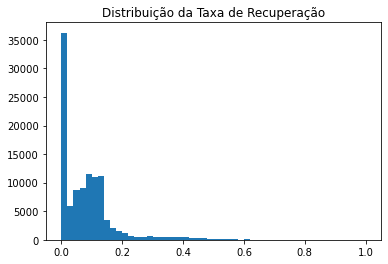

In [9]:
plt.title('Distribuição da Taxa de Recuperação')
plt.hist(LC_defaults['taxa_recuperacao'], bins = 50);

Criando variável para taxa de recuperação, onde será aplicada a regressão logística e se a `taxa_recuperacao` for zero, a taxa de recuperação será zero. Onde for maior do que zero, será usada a Regressão Linear para estimá-la.

In [10]:
LC_defaults['taxa_recuperacao_0_1'] = np.where(LC_defaults['taxa_recuperacao'] == 0, 0, 1)

### Exposure at Default - EAD
---

EAD, exposição em caso de inadimplência é o valor total ao qual uma instituição financeira está exposta quando um empréstimo entra em default. 

Pode ser calculado por:

`EAD = valor total financiado * fator de conversão de crédito`

#### Calculando o fator de conversão de crédito

- **funded_amnt:** O valor total comprometido com esse empréstimo naquele momento
- **total_rec_prncp:** Principal recebido até o momento

In [11]:
LC_defaults['fator_conversao_credito'] = (LC_defaults['funded_amnt'] - LC_defaults['total_rec_prncp']) / LC_defaults['funded_amnt']
LC_defaults['fator_conversao_credito'].describe()

count    109122.000000
mean          0.688478
std           0.224716
min           0.000000
25%           0.549790
50%           0.740939
75%           0.868476
max           1.000000
Name: fator_conversao_credito, dtype: float64

Observando a distribuição beta, a mesma da taxa de recuperação, que nesse caso será aplicada a Regressão Linear, já que fatores de conversão são mais homogeaneamente distribuídos. 

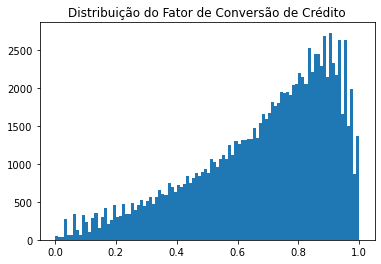

In [12]:
plt.title('Distribuição do Fator de Conversão de Crédito')
plt.hist(LC_defaults['fator_conversao_credito'], bins = 100);

---

*Esse dataset foi criado para a Regressão Linear do notebook de índice de perda por inadimplência, será junção das variáveis e dummies das variáveis selecionadas por WoE e IV com as taxas e fator de conversão criados neste notebook*

In [14]:
dados_WoE_VI = pd.read_csv('dados/dados_WoE_VI.csv')

In [15]:
# criando dummies para variáveis categóricas
var_dummies = [pd.get_dummies(dados_WoE_VI['purpose'], prefix = 'purpose', prefix_sep = ':'),
               pd.get_dummies(dados_WoE_VI['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
               pd.get_dummies(dados_WoE_VI['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
               pd.get_dummies(dados_WoE_VI['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':'),
               pd.get_dummies(dados_WoE_VI['grade'], prefix = 'grade', prefix_sep = ':')]

var_dummies  = pd.concat(var_dummies, axis = 1)
dados_WoE_VI = pd.concat([dados_WoE_VI, var_dummies], axis = 1)

In [16]:
df2 = pd.concat([dados_WoE_VI, LC_defaults[['taxa_recuperacao', 'taxa_recuperacao_0_1', 'fator_conversao_credito']]], axis = 1)
df2.fillna(0, inplace=True)

In [17]:
# retirando categorias para evitar multicolinearidade e variáveis das quais foram criados os dummies
df2.drop(['purpose:debt_consolidation', 'home_ownership:RENT',  
          'verification_status:Source Verified','loan_status', 
          'initial_list_status:f', 'grade:A', , 'home_ownership', 
          'verification_status', 'purpose', 'initial_list_status', 
          'grade'], axis = 1, inplace = True)

In [18]:
df2.to_csv('dados/dados_WoE_VI_LGD_EAD_regressao.csv', index=False)

---